# Instrução do Projeto

A Film Junky Union, uma nova comunidade para entusiastas de filmes clássicos, está desenvolvendo um sistema para filtrar e categorizar resenhas de filmes. O objetivo é treinar um modelo para detectar automaticamente resenhas negativas. Você usará um conjunto de dados de resenhas de filmes do IMDB com rotulagem de polaridade para criar um modelo para classificar resenhas como positivas e negativas. Ele precisará ter um valor F1 de pelo menos 0,85.

## Inicialização

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# a próxima linha fornece gráficos de melhor qualidade em telas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8')


In [4]:
# isso é para usar progress_apply, leia mais em https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()


## Carregar Dados

In [5]:
df_reviews = pd.read_csv('datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})


## AED

Vamos verificar o número de filmes e resenhas ao longo dos anos.

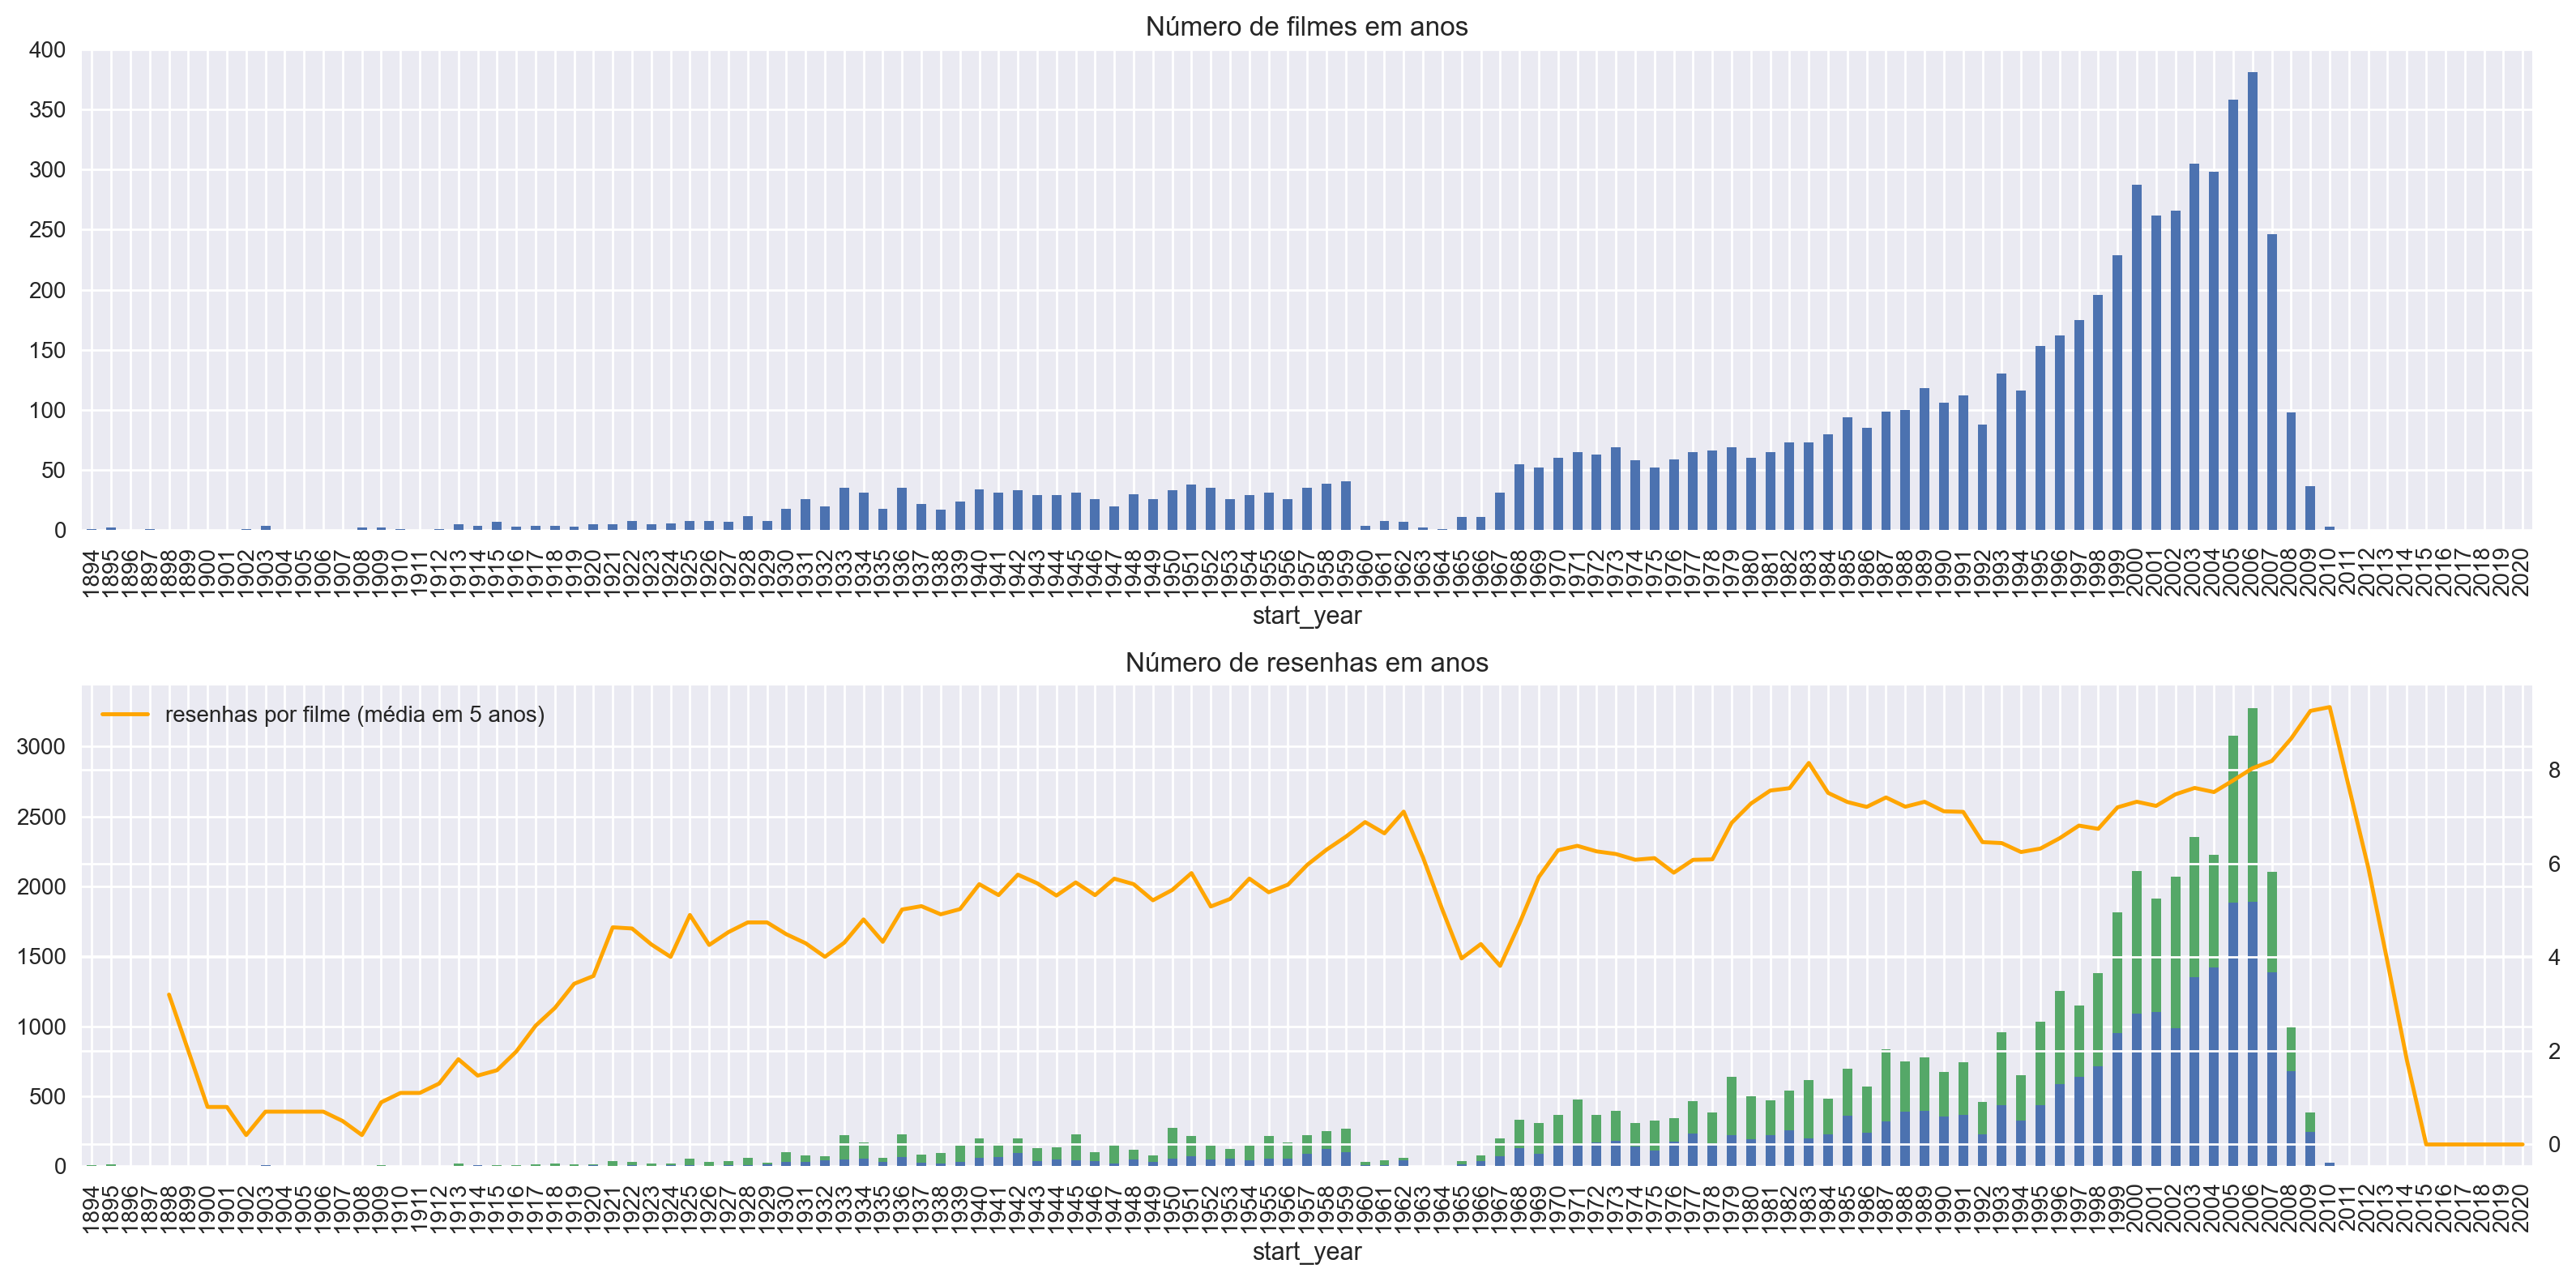

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = (
    df_reviews[["tconst", "start_year"]]
    .drop_duplicates()["start_year"]
    .value_counts()
    .sort_index()
)
dft1 = dft1.reindex(
    index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))
).fillna(0)
dft1.plot(kind="bar", ax=ax)
ax.set_title("Número de filmes em anos")

ax = axs[1]

dft2 = df_reviews.groupby(["start_year", "pos"])["pos"].count().unstack()
dft2 = dft2.reindex(
    index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))
).fillna(0)

dft2.plot(kind="bar", stacked=True, label="#reviews (neg, pos)", ax=ax)

dft2 = df_reviews["start_year"].value_counts().sort_index()
dft2 = dft2.reindex(
    index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))
).fillna(0)
dft3 = (dft2 / dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(
    color="orange", label="resenhas por filme (média em 5 anos)", ax=axt
)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc="upper left")

ax.set_title("Número de resenhas em anos")

fig.tight_layout()


Vamos verificar a distribuição do número de resenhas por filme com a contagem exata e o EDK (Estimativa de densidade kernel - só para saber como pode diferir da contagem exata)

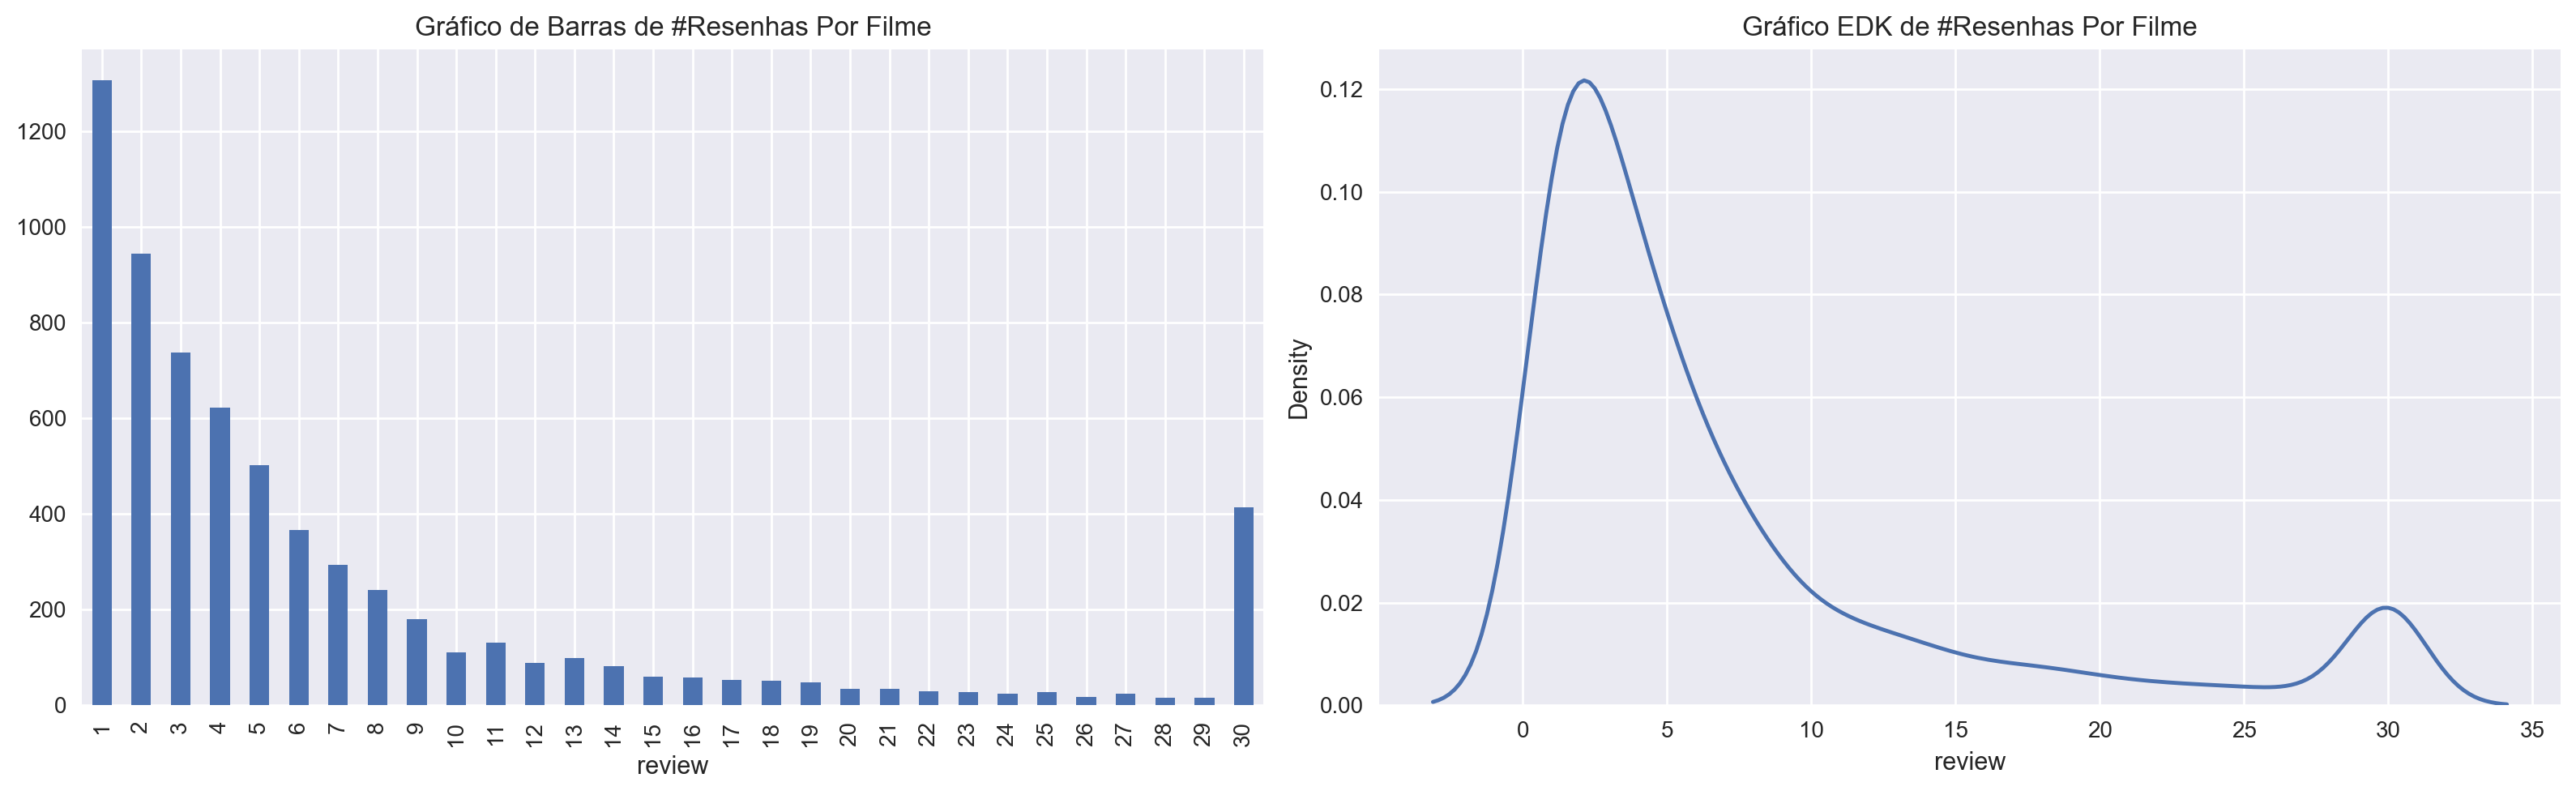

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = (
    df_reviews.groupby("tconst")["review"].count().value_counts().sort_index()
)
dft.plot.bar(ax=ax)
ax.set_title("Gráfico de Barras de #Resenhas Por Filme")

ax = axs[1]
dft = df_reviews.groupby("tconst")["review"].count()
sns.kdeplot(dft, ax=ax)
ax.set_title("Gráfico EDK de #Resenhas Por Filme")

fig.tight_layout()


In [8]:
df_reviews['pos'].value_counts()


pos
0    23715
1    23616
Name: count, dtype: int64

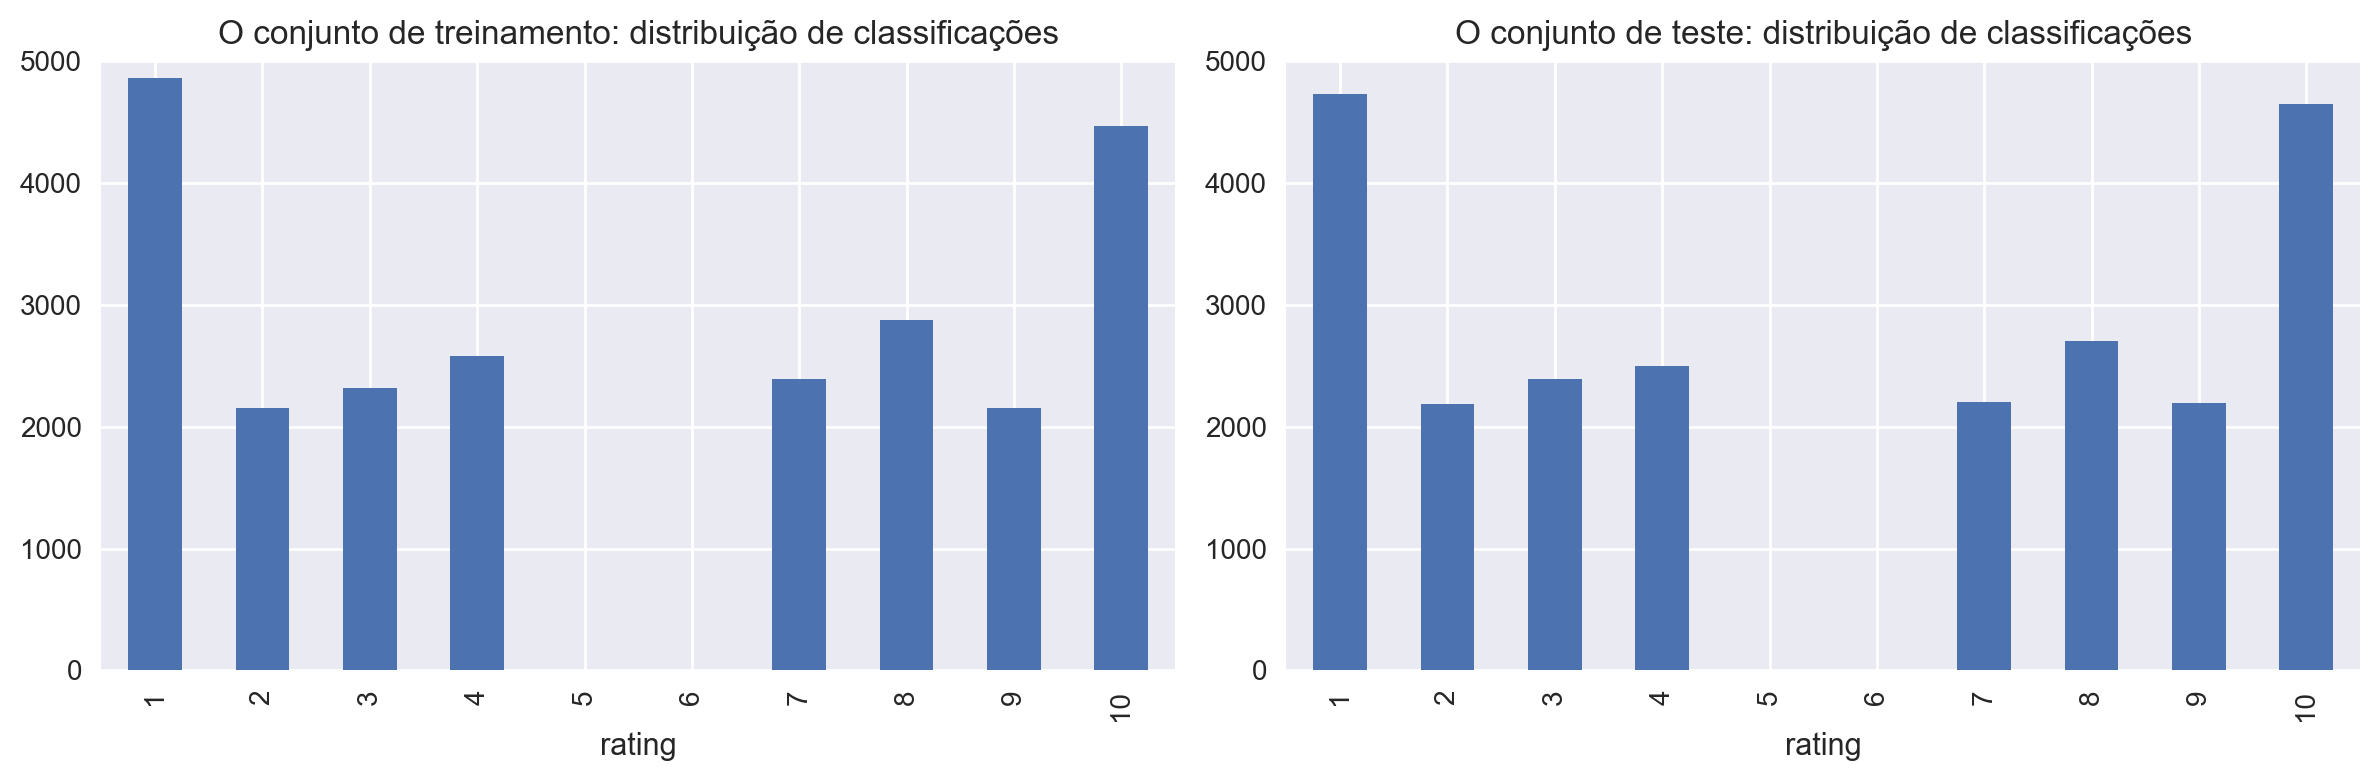

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = (
    df_reviews.query('ds_part == "train"')["rating"]
    .value_counts()
    .sort_index()
)
dft = dft.reindex(
    index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))
).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title("O conjunto de treinamento: distribuição de classificações")

ax = axs[1]
dft = (
    df_reviews.query('ds_part == "test"')["rating"].value_counts().sort_index()
)
dft = dft.reindex(
    index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))
).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title("O conjunto de teste: distribuição de classificações")

fig.tight_layout()


Distribuição de resenhas negativas e positivas ao longo dos anos para duas partes do conjunto de dados

C:\Users\luisv\AppData\Local\Temp\ipykernel_5376\3761435571.py:33: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color="blue", label="negative", kernel="epa", ax=ax)
C:\Users\luisv\AppData\Local\Temp\ipykernel_5376\3761435571.py:34: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color="green", label="positive", kernel="epa", ax=ax)
C:\Users\luisv\AppData\Local\Temp\ipykernel_5376\3761435571.py:65: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color="blue", label="negative", kernel="epa", ax=ax)
C:\Users\luisv\AppData\Local\Temp\ipykernel_5376\3761435571.py:66: UserWarning: 

Support for alter

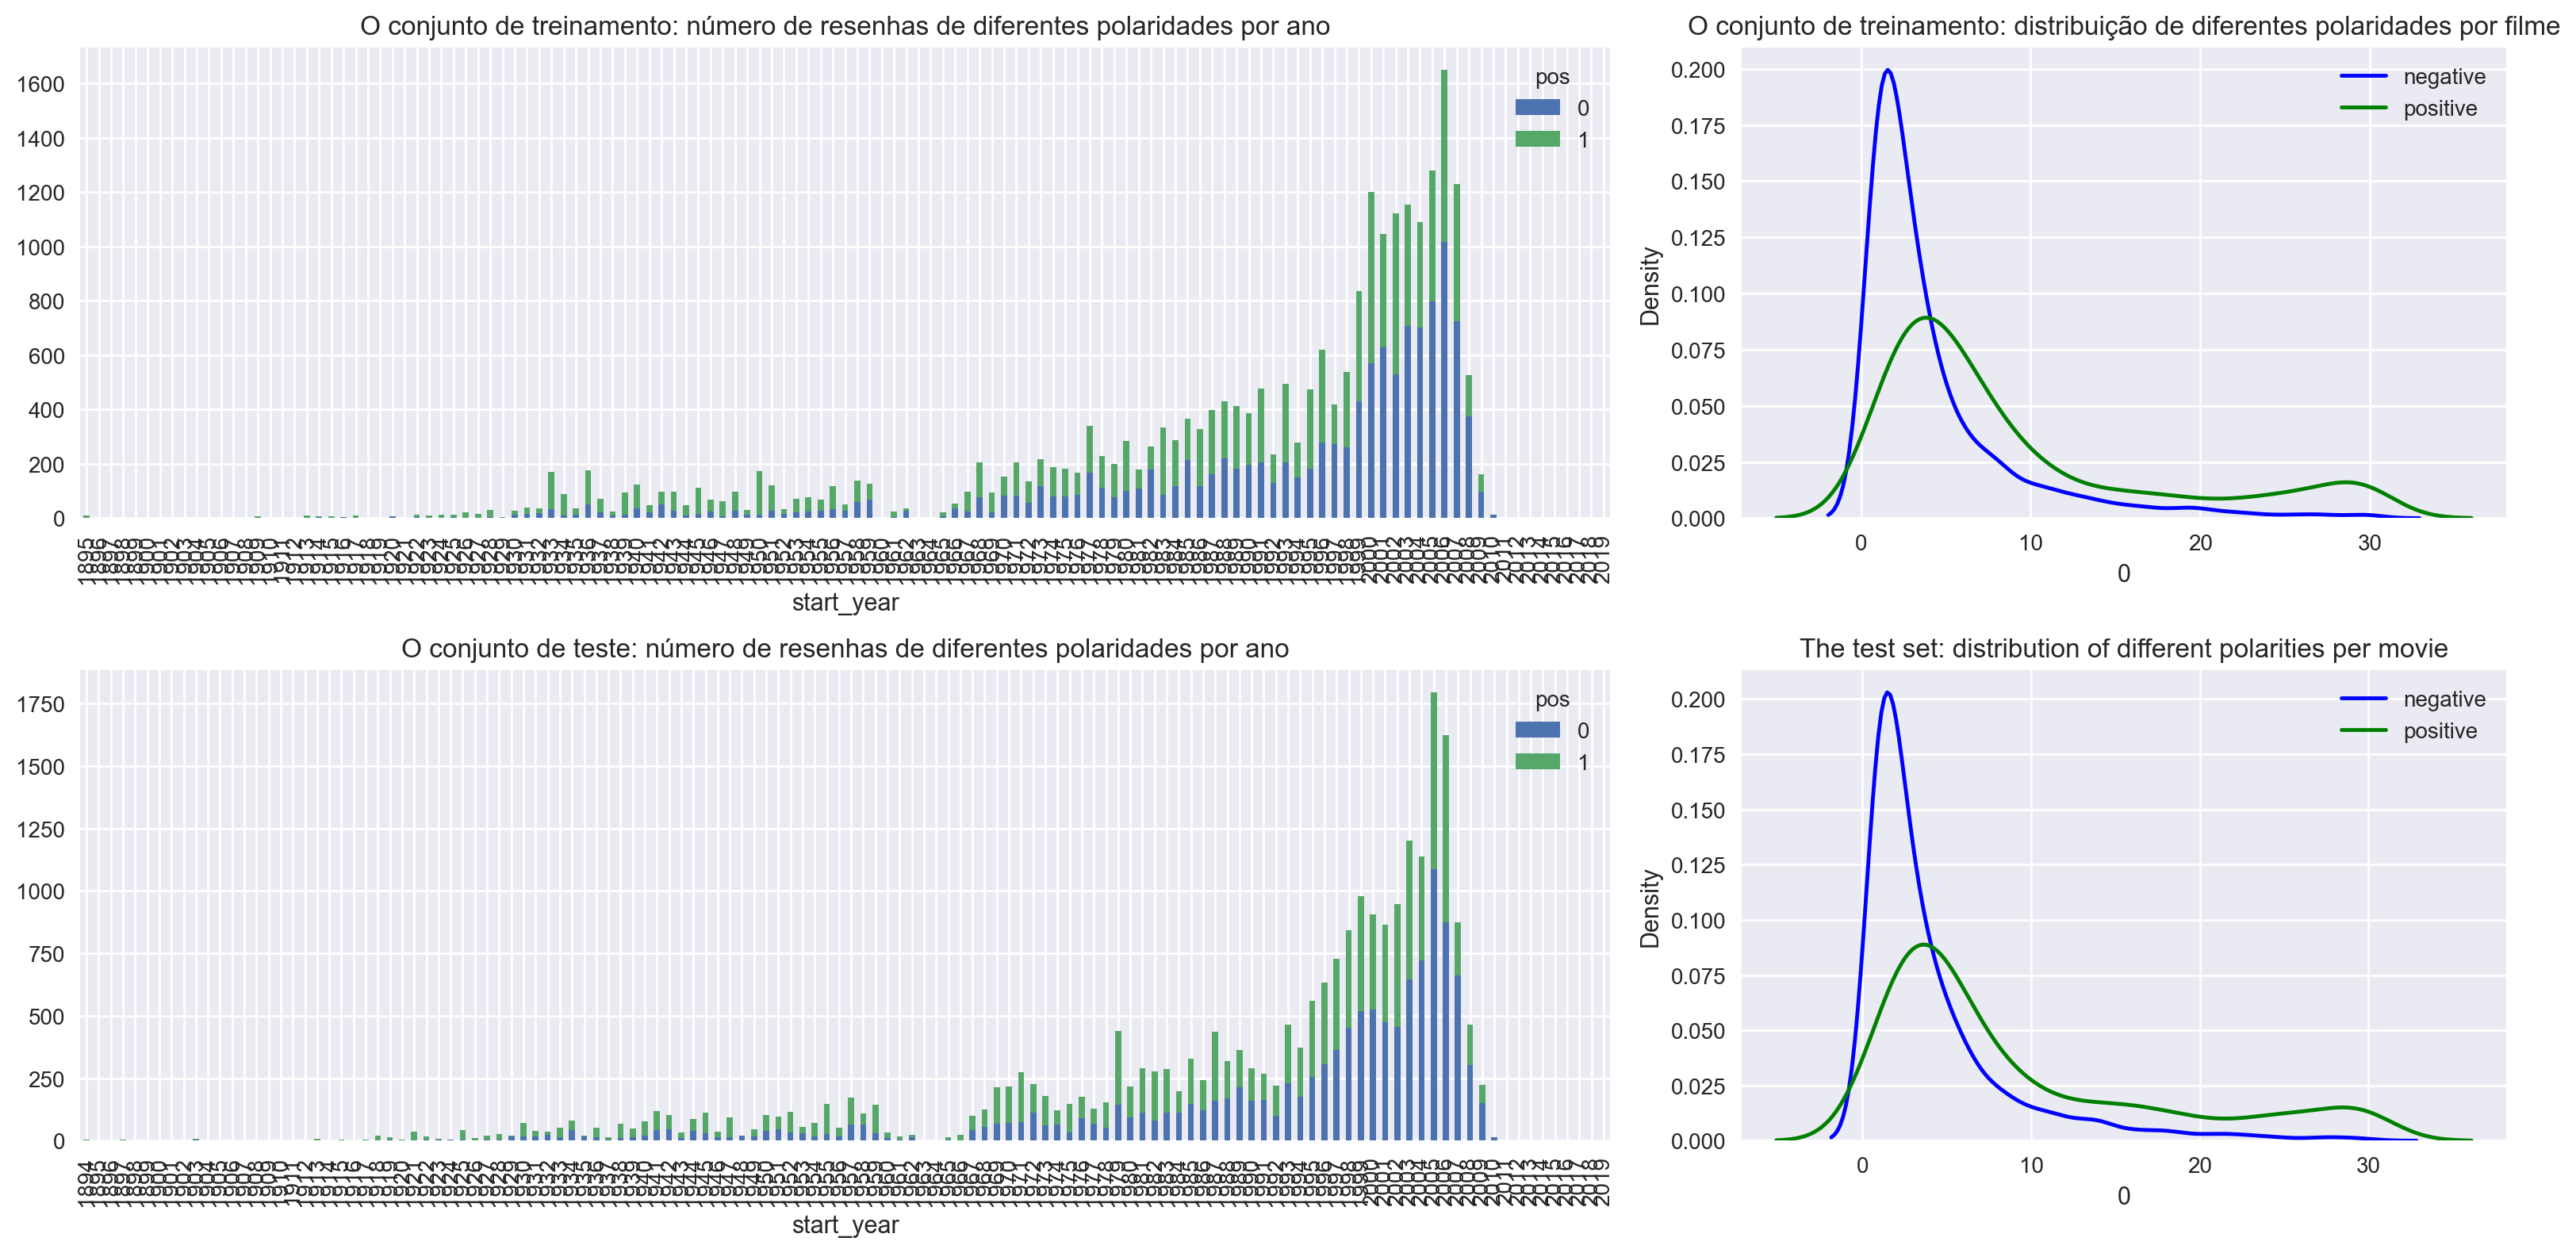

In [10]:
fig, axs = plt.subplots(
    2,
    2,
    figsize=(16, 8),
    gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)),
)

ax = axs[0][0]

dft = (
    df_reviews.query('ds_part == "train"')
    .groupby(["start_year", "pos"])["pos"]
    .count()
    .unstack()
)
dft.index = dft.index.astype("int")
dft = dft.reindex(
    index=np.arange(dft.index.min(), max(dft.index.max(), 2020))
).fillna(0)
dft.plot(kind="bar", stacked=True, ax=ax)
ax.set_title(
    "O conjunto de treinamento: número de resenhas de diferentes polaridades por ano"
)

ax = axs[0][1]

dft = (
    df_reviews.query('ds_part == "train"')
    .groupby(["tconst", "pos"])["pos"]
    .count()
    .unstack()
)
sns.kdeplot(dft[0], color="blue", label="negative", kernel="epa", ax=ax)
sns.kdeplot(dft[1], color="green", label="positive", kernel="epa", ax=ax)
ax.legend()
ax.set_title(
    "O conjunto de treinamento: distribuição de diferentes polaridades por filme"
)

ax = axs[1][0]

dft = (
    df_reviews.query('ds_part == "test"')
    .groupby(["start_year", "pos"])["pos"]
    .count()
    .unstack()
)
dft.index = dft.index.astype("int")
dft = dft.reindex(
    index=np.arange(dft.index.min(), max(dft.index.max(), 2020))
).fillna(0)
dft.plot(kind="bar", stacked=True, ax=ax)
ax.set_title(
    "O conjunto de teste: número de resenhas de diferentes polaridades por ano"
)

ax = axs[1][1]

dft = (
    df_reviews.query('ds_part == "test"')
    .groupby(["tconst", "pos"])["pos"]
    .count()
    .unstack()
)
sns.kdeplot(dft[0], color="blue", label="negative", kernel="epa", ax=ax)
sns.kdeplot(dft[1], color="green", label="positive", kernel="epa", ax=ax)
ax.legend()
ax.set_title("The test set: distribution of different polarities per movie")

fig.tight_layout()


## Procedimento de Avaliação

Compondo uma rotina de avaliação que pode ser utilizada para todos os modelos deste projeto

In [11]:
import sklearn.metrics as metrics


def evaluate_model(
    model, train_features, train_target, test_features, test_target
):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (
        ("train", train_features, train_target),
        ("test", test_features, test_target),
    ):
        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [
            metrics.f1_score(target, pred_proba >= threshold)
            for threshold in f1_thresholds
        ]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]["ROC AUC"] = roc_auc

        # Curva de precisão-revocação
        precision, recall, pr_thresholds = metrics.precision_recall_curve(
            target, pred_proba
        )
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]["APS"] = aps

        if type == "train":
            color = "blue"
        else:
            color = "green"

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(
            f1_thresholds,
            f1_scores,
            color=color,
            label=f"{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}",
        )
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = "orange" if threshold != 0.5 else "red"
            ax.plot(
                f1_thresholds[closest_value_idx],
                f1_scores[closest_value_idx],
                color=marker_color,
                marker="X",
                markersize=7,
            )
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel("threshold")
        ax.set_ylabel("F1")
        ax.legend(loc="lower center")
        ax.set_title("Valor F1")

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f"{type}, ROC AUC={roc_auc:.2f}")
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = "orange" if threshold != 0.5 else "red"
            ax.plot(
                fpr[closest_value_idx],
                tpr[closest_value_idx],
                color=marker_color,
                marker="X",
                markersize=7,
            )
        ax.plot([0, 1], [0, 1], color="grey", linestyle="--")
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.legend(loc="lower center")
        ax.set_title("Curva ROC")

        # Curva de precisão-revocação
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f"{type}, AP={aps:.2f}")
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = "orange" if threshold != 0.5 else "red"
            ax.plot(
                recall[closest_value_idx],
                precision[closest_value_idx],
                color=marker_color,
                marker="X",
                markersize=7,
            )
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel("recall")
        ax.set_ylabel("precision")
        ax.legend(loc="lower center")
        ax.set_title("PRC")

        # Armazenar Acurácia e F1 em eval_stats
        eval_stats[type]["Acurácia"] = metrics.accuracy_score(
            target, pred_target
        )
        eval_stats[type]["F1"] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(
        index=("Acurácia", "F1", "APS", "ROC AUC")
    )

    print(df_eval_stats)

    return


## Normalização

Assumimos que todos os modelos abaixo aceitam textos em letras minúsculas e sem dígitos, sinais de pontuação, etc.

In [12]:
df_reviews['review_norm'] = df_reviews["review"].str.lower()


## Treinar / Testar Conjunto

Felizmente, todo o conjunto de dados já está dividido em partes de treinamento/teste. A opção correspondente é 'ds_part'.

In [13]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train["pos"]
test_target = df_reviews_test["pos"]

print(df_reviews_train.shape)
print(df_reviews_test.shape)


(23796, 18)
(23535, 18)


## Trabalhando com modelos

### Modelo 0 - Constante

In [14]:
from sklearn.dummy import DummyClassifier


          train  test
Acurácia    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


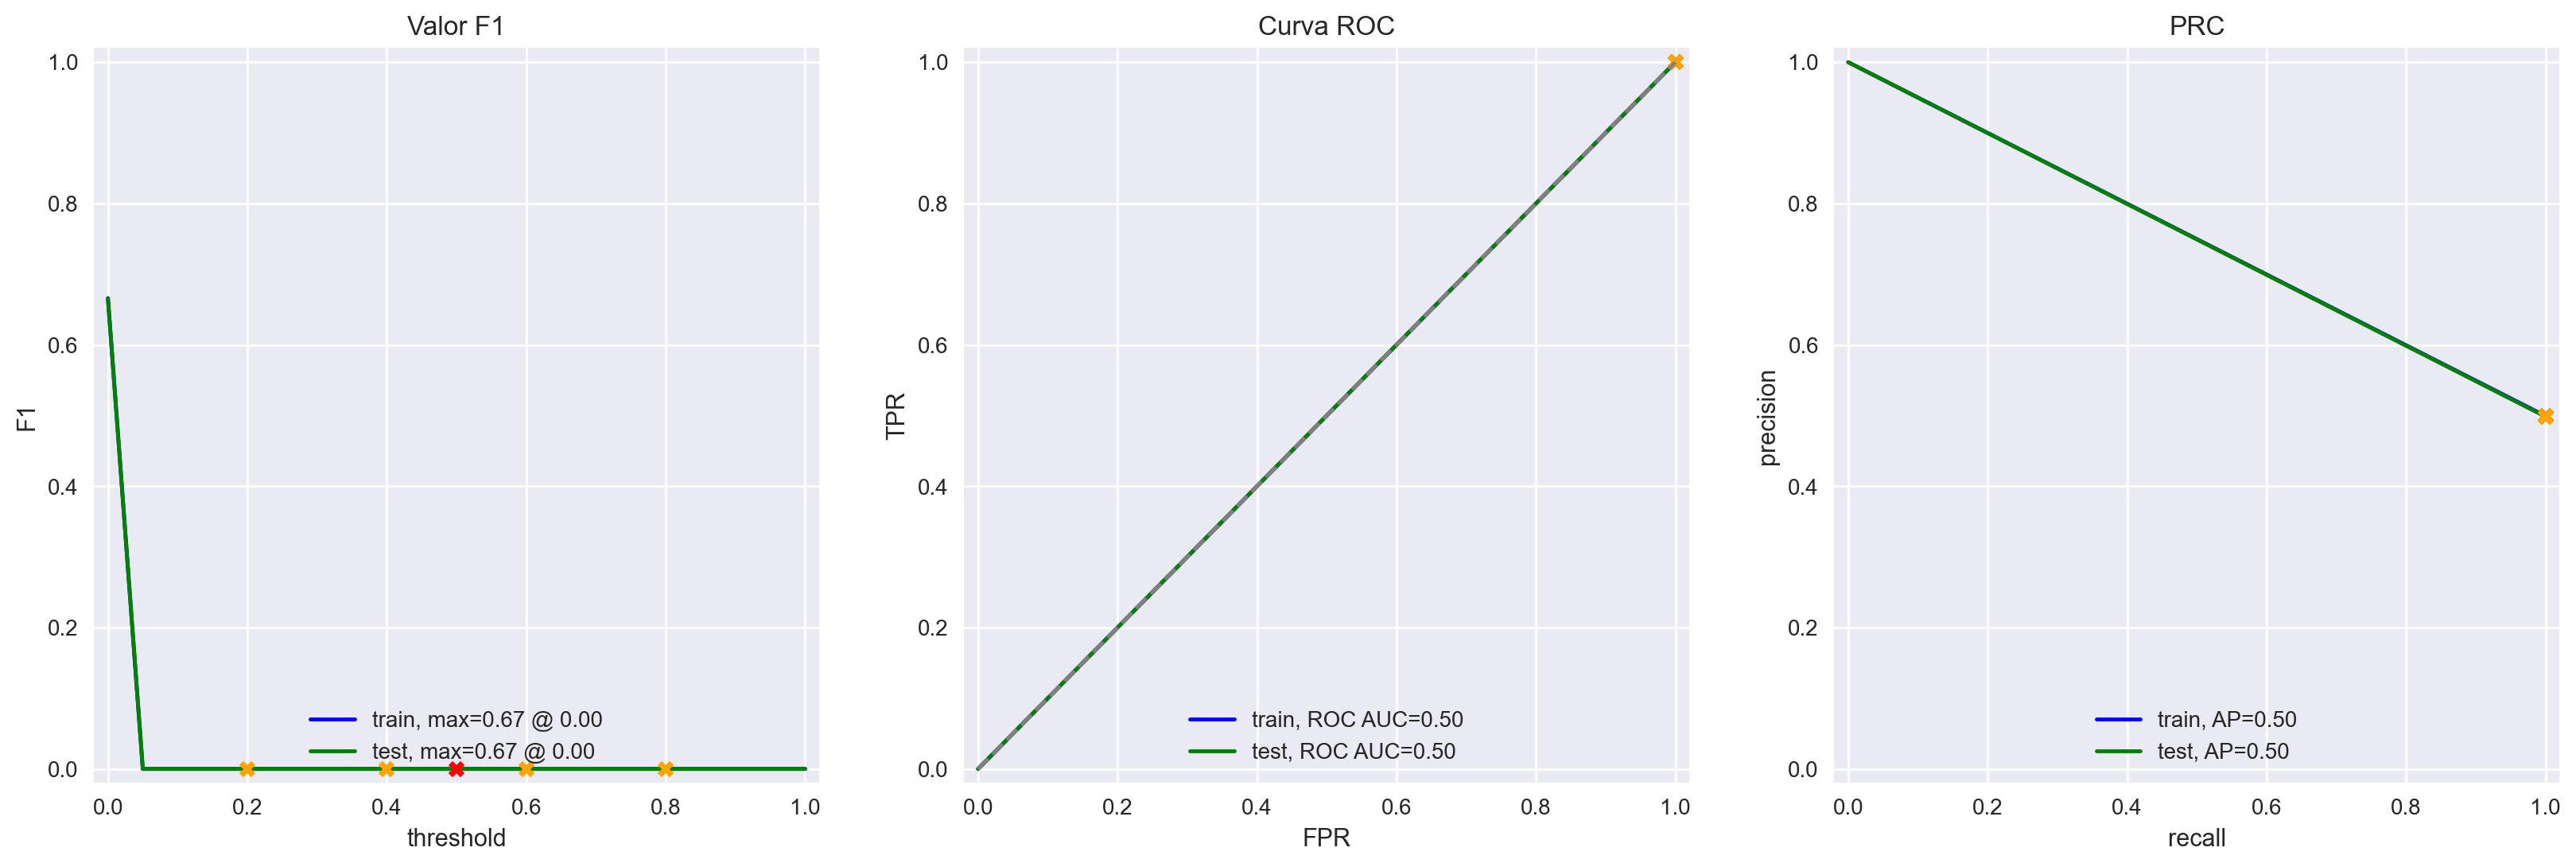

In [15]:
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(df_reviews_train["review_norm"], train_target)
evaluate_model(
    dummy_model,
    df_reviews_train["review_norm"],
    train_target,
    df_reviews_test["review_norm"],
    test_target,
)


### Modelo 1 - NLTK, TF-IDF e Regressão Linear

TF-IDF

In [16]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords


In [17]:
train_corpus = df_reviews_train["review_norm"].tolist()
stop_words = stopwords.words("english")


In [18]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf_train = count_tf_idf.fit_transform(train_corpus)

train_features_1 = tf_idf_train
target_train = df_reviews_train["pos"]

test_corpus = df_reviews_test["review_norm"].tolist()
stop_words = stopwords.words("english")
tf_idf_test = count_tf_idf.transform(test_corpus)

test_features_1 = tf_idf_test
target_test = df_reviews_test["pos"]

model_1 = LogisticRegression(max_iter=1000)
model_1.fit(train_features_1, target_train)
pred_test = model_1.predict(test_features_1)


          train  test
Acurácia   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


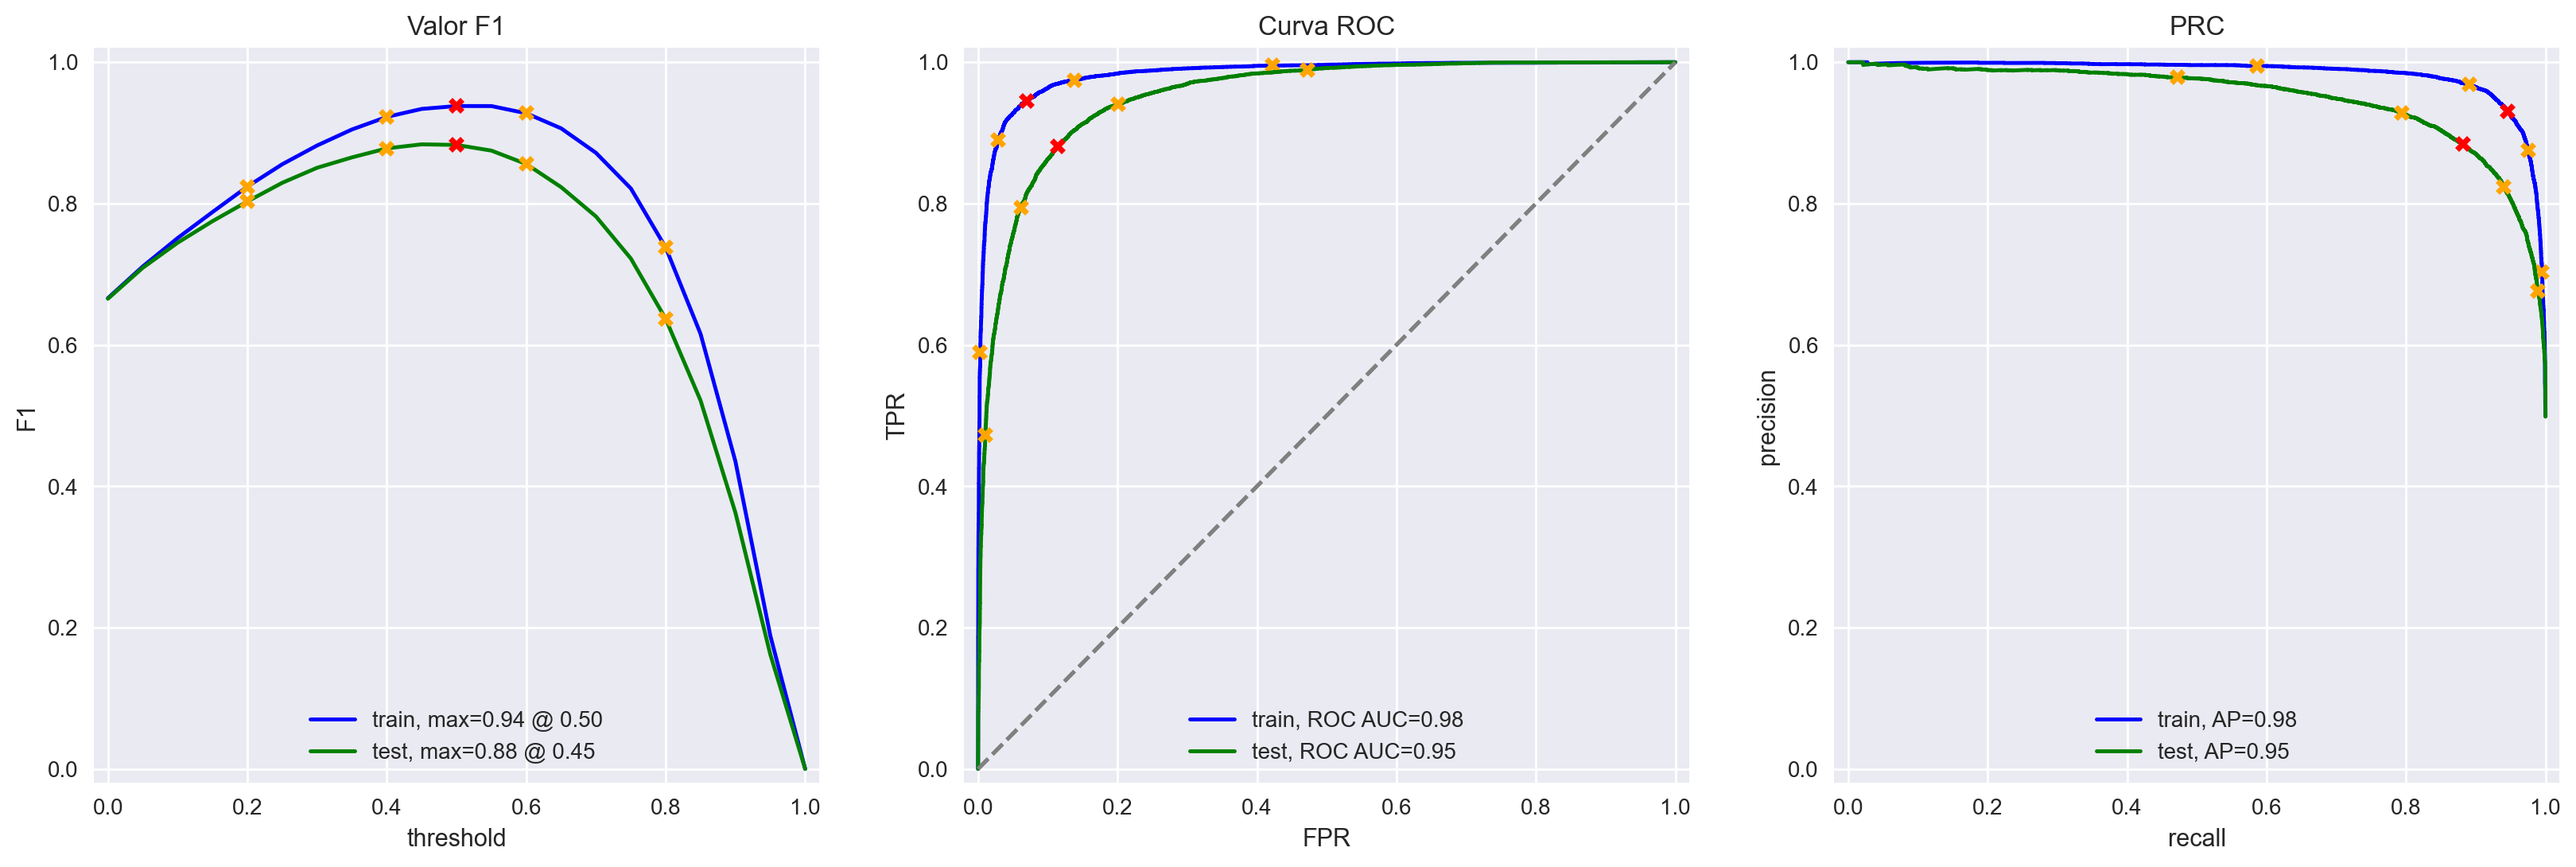

In [19]:
evaluate_model(
    model_1, train_features_1, train_target, test_features_1, test_target
)


### Modelo 3 - spaCy, TF-IDF e Regressão Linear

In [22]:
import spacy

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])


In [23]:
def text_preprocessing_3(text):

    doc = nlp(text)
    # tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]

    return " ".join(tokens)


In [24]:
df_reviews["review_norm"] = df_reviews["review_norm"].progress_apply(
    text_preprocessing_3
)


  0%|          | 0/47331 [00:00<?, ?it/s]

In [25]:
count_tf_idf_2 = TfidfVectorizer(stop_words=stop_words)
tf_idf_train_2 = count_tf_idf_2.fit_transform(train_corpus)

train_features_2 = tf_idf_train
target_train = df_reviews_train["pos"]

test_corpus = df_reviews_test["review_norm"].tolist()
stop_words = stopwords.words("english")
tf_idf_test_2 = count_tf_idf_2.transform(test_corpus)

test_features_2 = tf_idf_test_2
target_test = df_reviews_test["pos"]

model_2 = LogisticRegression(max_iter=1000)
model_2.fit(train_features_2, target_train)
pred_test = model_2.predict(test_features_2)


          train  test
Acurácia   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


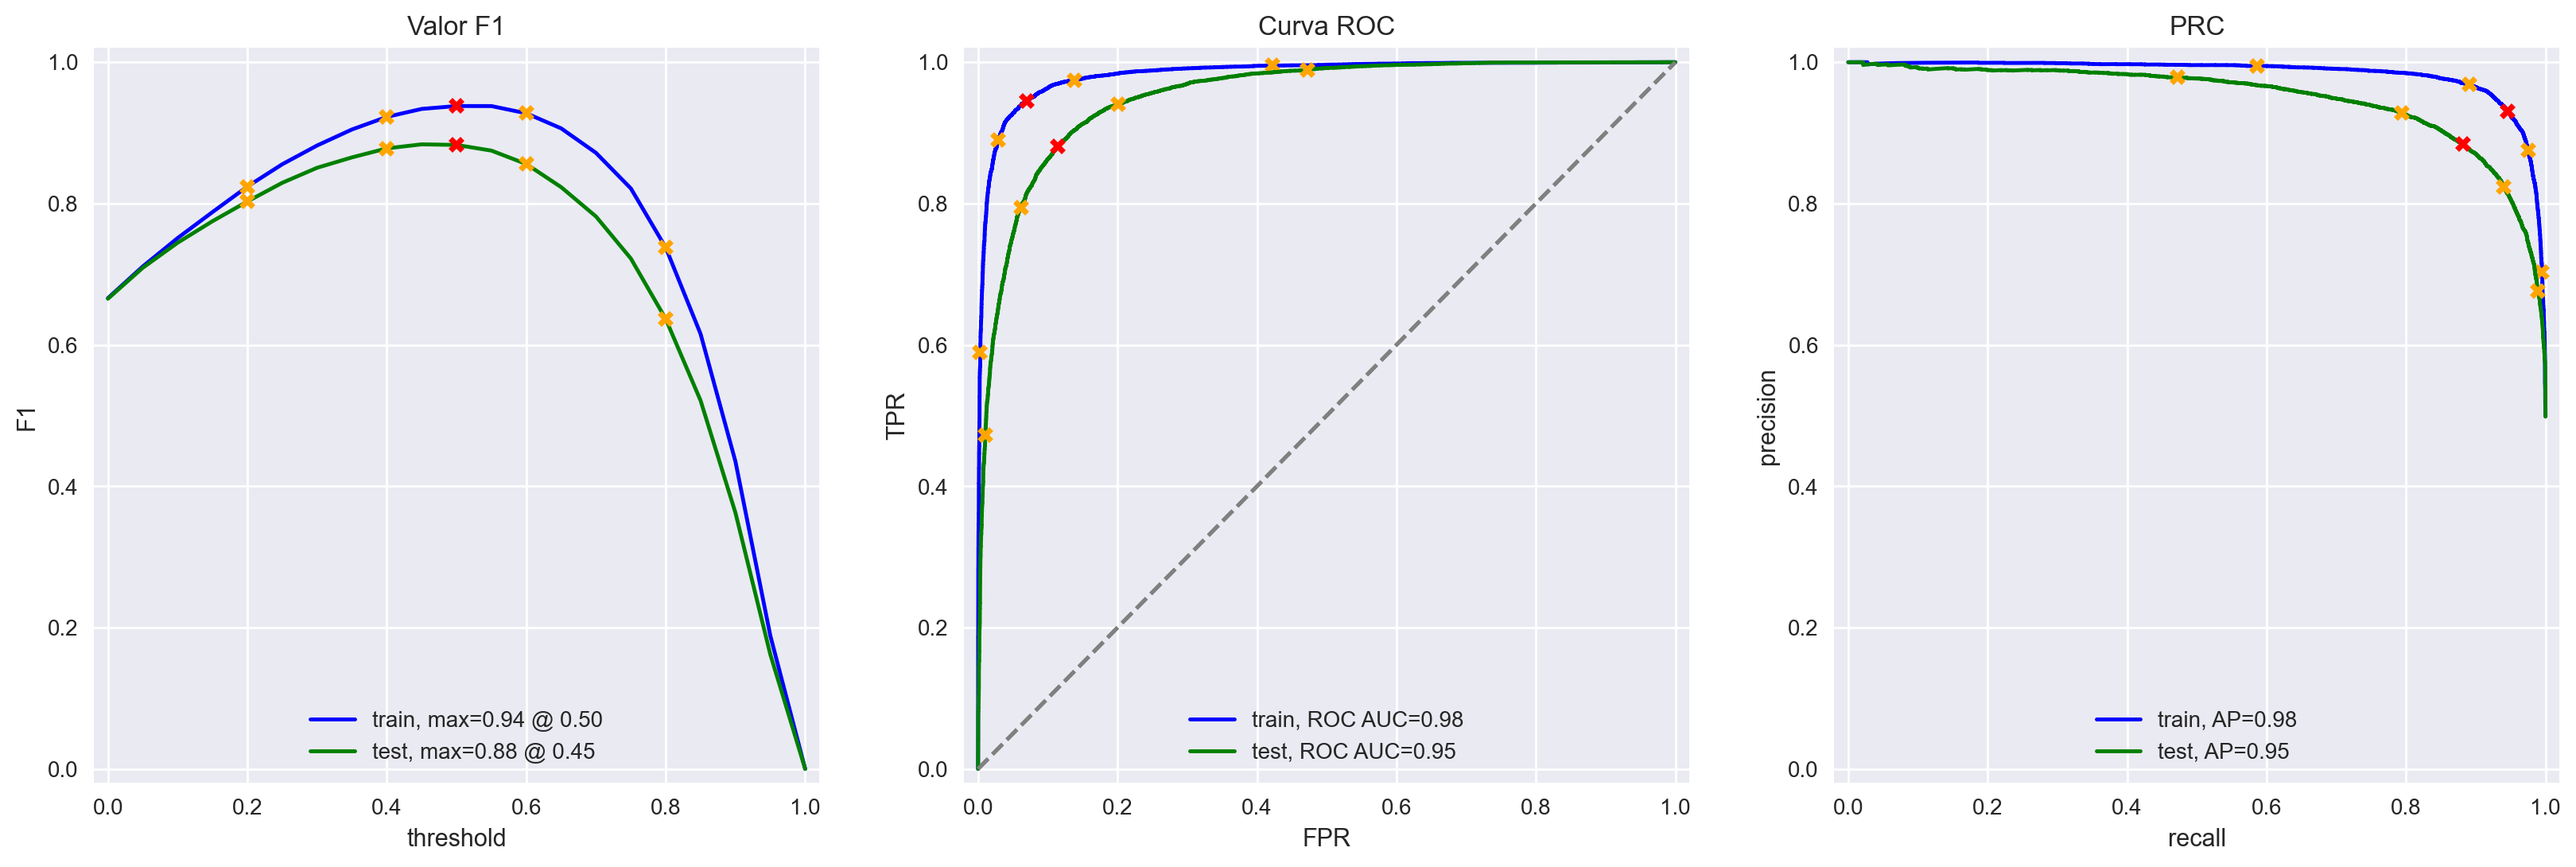

In [26]:
evaluate_model(
    model_2, train_features_2, target_train, test_features_2, target_test
)


### Modelo 4 - SpaCy, TF-IDF e LGBMClassifier

In [27]:
from lightgbm import LGBMClassifier


In [28]:
count_tf_idf_3 = TfidfVectorizer(stop_words=stop_words)
tf_idf_train_3 = count_tf_idf_3.fit_transform(train_corpus)

train_features_3 = tf_idf_train
target_train = df_reviews_train["pos"]

test_corpus = df_reviews_test["review_norm"].tolist()
stop_words = stopwords.words("english")
tf_idf_test_3 = count_tf_idf_3.transform(test_corpus)

test_features_3 = tf_idf_test_3
target_test = df_reviews_test["pos"]

model_3 = LogisticRegression(max_iter=1000)
model_3.fit(train_features_3, target_train)
pred_test = model_3.predict(test_features_3)


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.715981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 521069
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 11691
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


c:\Users\luisv\DEVinatea\DEVinatea\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\luisv\DEVinatea\DEVinatea\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\luisv\DEVinatea\DEVinatea\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\luisv\DEVinatea\DEVinatea\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


          train  test
Acurácia   0.91  0.86
F1         0.91  0.86
APS        0.97  0.94
ROC AUC    0.97  0.94


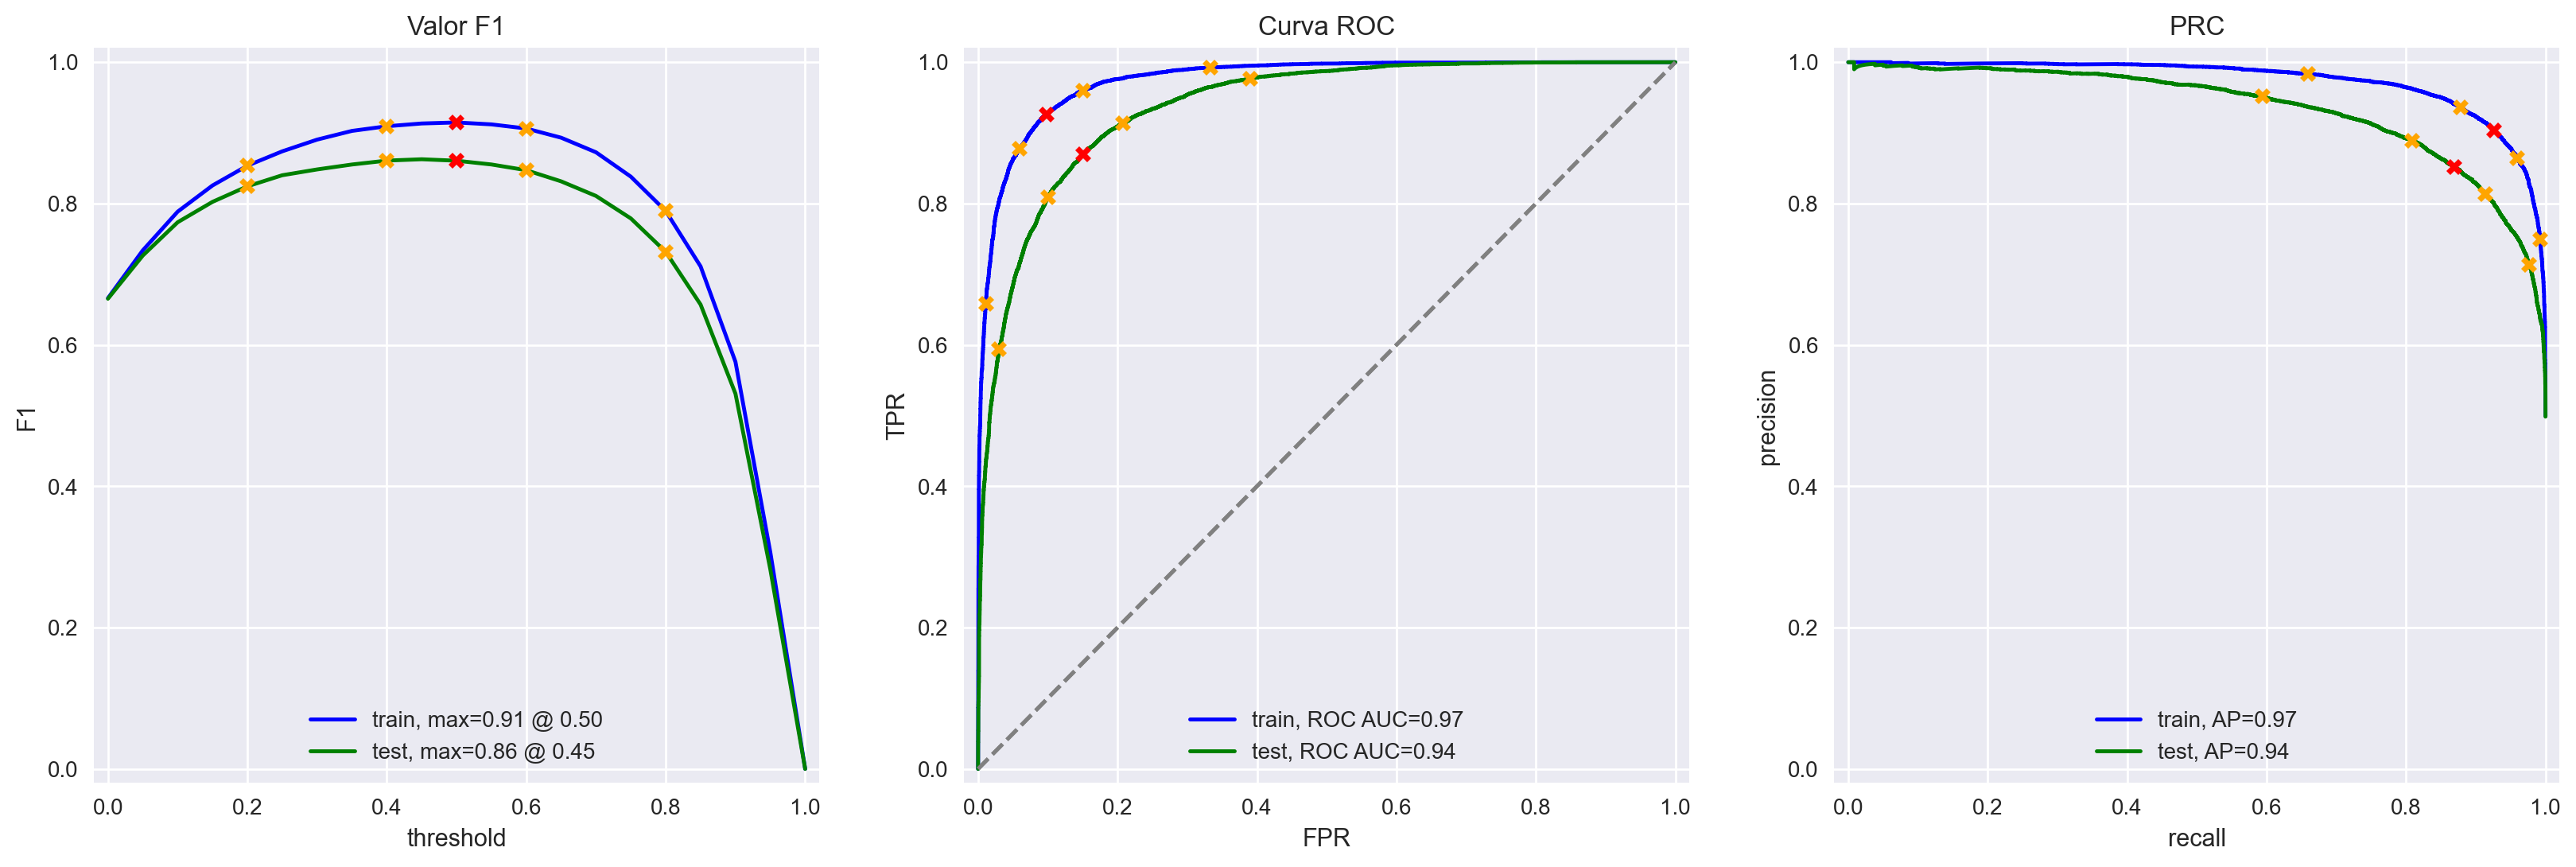

In [29]:
model_3 = LGBMClassifier(n_estimators=100, random_state=42)
model_3.fit(train_features_3, target_train)

evaluate_model(
    model_3, train_features_3, target_train, test_features_3, target_test
)


## Minhas Resenhas

In [30]:
# sinta-se à vontade para remover completamente essas resenhas e experimentar seus modelos nas suas próprias resenhas, as abaixo são apenas exemplos

my_reviews = pd.DataFrame(
    [
        "Eu simplesmente não gostei, não é meu tipo de filme.",
        "Bem, eu fiquei entediado e dormi no meio do filme.",
        "Eu fiquei realmente fascinado com o filme",
        "Os atores pareciam muito velhos e desinteressados, e mesmo assim foram pagos para participar do filme. Que roubo de dinheiro sem vergonha.",
        "Eu não esperava que a nova versão fosse tão boa! Os escritores realmente se importaram com o material original",
        "O filme tem seus prós e contras, mas eu sinto que em geral é um filme decente. Eu posso me imaginar indo assistir novamente.",
        "Que tentativa podre de comédia. Nem uma única piada cai, todo mundo age de forma irritante e barulhenta, nem crianças não vão gostar disso!",
        "Lançar na Netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após episódio, deste emocionante e inteligente novo drama.",
    ],
    columns=["review"],
)

my_reviews["review_norm"] = my_reviews["review"].str.lower()

my_reviews


,review,review_norm
0,"Eu simplesmente não gostei, não é meu tipo de ...","eu simplesmente não gostei, não é meu tipo de ..."
1,"Bem, eu fiquei entediado e dormi no meio do fi...","bem, eu fiquei entediado e dormi no meio do fi..."
2,Eu fiquei realmente fascinado com o filme,eu fiquei realmente fascinado com o filme
3,Os atores pareciam muito velhos e desinteressa...,os atores pareciam muito velhos e desinteressa...
4,Eu não esperava que a nova versão fosse tão bo...,eu não esperava que a nova versão fosse tão bo...
5,"O filme tem seus prós e contras, mas eu sinto ...","o filme tem seus prós e contras, mas eu sinto ..."
6,Que tentativa podre de comédia. Nem uma única ...,que tentativa podre de comédia. nem uma única ...
7,Lançar na Netflix foi uma jogada corajosa e eu...,lançar na netflix foi uma jogada corajosa e eu...


### Modelo 1

In [33]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


0.51:  eu simplesmente não gostei, não é meu tipo de filme.
0.49:  bem, eu fiquei entediado e dormi no meio do filme.
0.65:  eu fiquei realmente fascinado com o filme
0.50:  os atores pareciam muito velhos e desinteressados, e mesmo assim foram pagos para participar do film
0.44:  eu não esperava que a nova versão fosse tão boa! os escritores realmente se importaram com o materia
0.50:  o filme tem seus prós e contras, mas eu sinto que em geral é um filme decente. eu posso me imaginar 
0.54:  que tentativa podre de comédia. nem uma única piada cai, todo mundo age de forma irritante e barulhe
0.48:  lançar na netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após


### Modelo 2

In [34]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(count_tf_idf_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


0.51:  eu simplesmente não gostei, não é meu tipo de filme.
0.49:  bem, eu fiquei entediado e dormi no meio do filme.
0.65:  eu fiquei realmente fascinado com o filme
0.50:  os atores pareciam muito velhos e desinteressados, e mesmo assim foram pagos para participar do film
0.44:  eu não esperava que a nova versão fosse tão boa! os escritores realmente se importaram com o materia
0.50:  o filme tem seus prós e contras, mas eu sinto que em geral é um filme decente. eu posso me imaginar 
0.54:  que tentativa podre de comédia. nem uma única piada cai, todo mundo age de forma irritante e barulhe
0.48:  lançar na netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após


### Modelo 3

In [35]:
texts = my_reviews['review_norm']

tfidf_vectorizer_3 = count_tf_idf_3
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


0.63:  eu simplesmente não gostei, não é meu tipo de filme.
0.63:  bem, eu fiquei entediado e dormi no meio do filme.
0.63:  eu fiquei realmente fascinado com o filme
0.63:  os atores pareciam muito velhos e desinteressados, e mesmo assim foram pagos para participar do film
0.51:  eu não esperava que a nova versão fosse tão boa! os escritores realmente se importaram com o materia
0.63:  o filme tem seus prós e contras, mas eu sinto que em geral é um filme decente. eu posso me imaginar 
0.64:  que tentativa podre de comédia. nem uma única piada cai, todo mundo age de forma irritante e barulhe
0.63:  lançar na netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após


c:\Users\luisv\DEVinatea\DEVinatea\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Conclusões

**Modelo 1:** *Observamos que o modelo 1, que utiliza a vetorização TF-IDF simples e regressão logística, apresenta um desempenho razoável com acurácia e F1 de 0.88 de teste.* 

O resultado da review: 

```text
0.51:  eu simplesmente não gostei, não é meu tipo de filme.
0.49:  bem, eu fiquei entediado e dormi no meio do filme.
0.65:  eu fiquei realmente fascinado com o filme
0.50:  os atores pareciam muito velhos e desinteressados, e mesmo assim foram pagos para participar do film
0.44:  eu não esperava que a nova versão fosse tão boa! os escritores realmente se importaram com o materia
0.50:  o filme tem seus prós e contras, mas eu sinto que em geral é um filme decente. eu posso me imaginar 
0.54:  que tentativa podre de comédia. nem uma única piada cai, todo mundo age de forma irritante e barulhe
0.48:  lançar na netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após
```

indica que o modelo está tendo dificuldades para classificar resenhas neutras ou ambíguas, resultando em probabilidades próximas de 0.5.


**Modelo 2:** *Observamos que o modelo 2, que utiliza spaCy para vetorização e classificação, apresenta um desempenho razoável com acurácia e F1 de 0.88 de teste.* 

O resultado da review: 

```text
0.51:  eu simplesmente não gostei, não é meu tipo de filme.
0.49:  bem, eu fiquei entediado e dormi no meio do filme.
0.65:  eu fiquei realmente fascinado com o filme
0.50:  os atores pareciam muito velhos e desinteressados, e mesmo assim foram pagos para participar do film
0.44:  eu não esperava que a nova versão fosse tão boa! os escritores realmente se importaram com o materia
0.50:  o filme tem seus prós e contras, mas eu sinto que em geral é um filme decente. eu posso me imaginar 
0.54:  que tentativa podre de comédia. nem uma única piada cai, todo mundo age de forma irritante e barulhe
0.48:  lançar na netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após
```

indica que o modelo também está tendo dificuldades para classificar resenhas neutras ou ambíguas, resultando em probabilidades próximas de 0.5.


**Modelo 3:** *Observamos que o modelo 3, que utiliza spaCy e LightGBM, apresenta um desempenho ligeiramente abaixo dos anteriores com acurácia e F1 de 0.86 de teste.* 

O resultado da review: 

```text
0.63:  eu simplesmente não gostei, não é meu tipo de filme.
0.63:  bem, eu fiquei entediado e dormi no meio do filme.
0.63:  eu fiquei realmente fascinado com o filme
0.63:  os atores pareciam muito velhos e desinteressados, e mesmo assim foram pagos para participar do film
0.51:  eu não esperava que a nova versão fosse tão boa! os escritores realmente se importaram com o materia
0.63:  o filme tem seus prós e contras, mas eu sinto que em geral é um filme decente. eu posso me imaginar 
0.64:  que tentativa podre de comédia. nem uma única piada cai, todo mundo age de forma irritante e barulhe
0.63:  lançar na netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após
```

indica que o modelo está tendendo a classificar muitas resenhas como positivas, resultando em probabilidades mais altas, mesmo para resenhas que parecem negativas ou neutras.


# Checklist

- [x]  O caderno foi aberto
- [ ]  Os dados de texto são carregados e pré-processados para vetorização
- [ ]  Os dados de texto são transformados em vetores
- [ ]  Os modelos são treinados e testados
- [ ]  O limiar da métrica foi atingido
- [ ]  Todas as células de código estão organizadas na ordem de sua execução
- [ ]  Todas as células de código podem ser executadas sem erros
- [ ]  Há conclusões 